In [20]:
# Python Module with Class
# for Vectorized Backtesting
# of SMA-based Strategies

import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import brute

class SMAVectorBacktester(object):
    
    ''' Class for the vectorized backtesting of SMA-based trading strategies.
    
    Attributes
    ==========
    symbol: str
        RIC symbol with which to work
    SMA1: int
        time window in days for shorter SMA
    SMA2: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    
    Methods
    ======= 
    get_data:
        retrieves and prepares the base data set 
    set_parameters:
        sets one or two new SMA parameters 
    run_strategy:
        runs the backtest for the SMA-based strategy 
    plot_results:
        plots the performance of the strategy compared to the symbol 
    update_and_run:
        updates SMA parameters and returns the (negative) absolute performance 
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
        
    def __init__(self, symbol, SMA1, SMA2, start, end): 
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.results = None 
        self.get_data()
        
    
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = yf.download(self.symbol, start=self.start, end=self.end)
        raw = raw[raw.index.weekday<=4]
        raw = pd.DataFrame(raw['Close'])
        raw.rename(columns={'Close': 'price'}, inplace=True) 
        raw['return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['price'].rolling(self.SMA1).mean() 
        raw['SMA2'] = raw['price'].rolling(self.SMA2).mean() 
        self.data = raw
        
        
    def set_parameters(self, SMA1=None, SMA2=None):
        ''' Updates SMA parameters and resp. time series. 
        '''
        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['price'].rolling(self.SMA1).mean() 
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['price'].rolling(self.SMA2).mean()
            

    def run_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['position'] = np.where(data['SMA1'] > data['SMA2'], -1, 1) 
        data['strategy'] = data['position'].shift(1) * data['return'] 
        data.dropna(inplace=True)
        data['creturns'] = data['return'].cumsum().apply(np.exp) 
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp) 
        self.results = data
        # gross performance of the strategy
        aperf = data['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - data['creturns'].iloc[-1]
        return round(aperf, 2), round(operf, 2)
    
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.') 
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,self.SMA1, self.SMA2) 
        self.results[['creturns', 'cstrategy']].plot(title=title,figsize=(10, 6))
            
            
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns negative absolute performance
        (for minimazation algorithm).
        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1])) 
        return -self.run_strategy()[0]
    
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.
        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None) 
        return opt, -self.update_and_run(opt)
    

In [21]:
#
# Python Module with Class
# for Vectorized Backtesting
# of Machine Learning-Based Strategies
#

from sklearn import linear_model


class ScikitVectorBacktester(SMAVectorBacktester):
    ''' Class for the vectorized backtesting of machine learning-based trading strategies.
    
        Attributes
        ==========
        symbol: str
            TR RIC (financial instrument) to work with
        start: str
            start date for data selection
        end: str
            end date for data selection
        amount: int, float
            amount to be invested at the beginning
        tc: float
            proportional transaction costs (e.g., 0.5% = 0.005) per trade 
        model: str
            either 'regression' or 'logistic'
            
        Methods 
        ======= 
        get_data:
            retrieves and prepares the base data set 
        select_data:
            selects a sub-set of the data 
        prepare_features:
            prepares the features data for the model fitting 
        fit_model:
            implements the fitting step 
        run_strategy:
            runs the backtest for the regression-based strategy 
        plot_results:
            plots the performance of the strategy compared to the symbol
    '''
    
    
    def __init__(self, symbol, start, end, amount, tc, model): 
        self.symbol = symbol
        self.start = start
        self.end = end
        self.amount = amount 
        self.tc = tc 
        self.results = None
        if model == 'regression':
            self.model = linear_model.LinearRegression() 
        elif model == 'logistic':
            self.model = linear_model.LogisticRegression(C=1e6, solver='lbfgs', multi_class='ovr', max_iter=10000)
        else:
            raise ValueError('Model not known or not yet implemented.')
        self.get_data()
        
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = yf.download(self.symbol, start=self.start, end=self.end)
        raw = raw[raw.index.weekday<=4]
        raw = pd.DataFrame(raw['Close'])
        raw.rename(columns={'Close': 'price'}, inplace=True) 
        raw['returns'] = np.log(raw / raw.shift(1))
        self.data = raw
        

    def prepare_features(self, start, end):
        ''' Prepares the feature columns for the regression and prediction steps. '''
        self.data_subset = self.select_data(start, end)
        self.feature_columns = []
        for lag in range(1, self.lags + 1):
            col = 'lag_{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag) 
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)


    def fit_model(self, start, end):
        ''' Implements the fitting step.
        '''
        self.prepare_features(start, end) 
        self.model.fit(self.data_subset[self.feature_columns],np.sign(self.data_subset['returns']))
        
    
    def select_data(self, start, end):
        ''' Selects sub-sets of the financial data. '''
        data = self.data[(self.data.index >= start) & (self.data.index <= end)].copy()
        return data
        
    
    def run_strategy(self, start_in, end_in, start_out, end_out, lags=3): 
        ''' Backtests the trading strategy.
        '''
        self.lags = lags
        self.fit_model(start_in, end_in)
        # data = self.select_data(start_out, end_out) 
        self.prepare_features(start_out, end_out) 
        prediction = self.model.predict(self.data_subset[self.feature_columns]) 
        self.data_subset['prediction'] = prediction 
        self.data_subset['strategy'] = (self.data_subset['prediction'] * self.data_subset['returns']) 
        # determine when a trade takes place
        trades = self.data_subset['prediction'].diff().fillna(0) != 0 
        # subtract transaction costs from return when trade takes place 
        self.data_subset['strategy'][trades] -= self.tc 
        self.data_subset['creturns'] = (self.amount * self.data_subset['returns'].cumsum().apply(np.exp)) 
        self.data_subset['cstrategy'] = (self.amount * self.data_subset['strategy'].cumsum().apply(np.exp)) 
        self.results = self.data_subset
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1] 
        return round(aperf, 2), round(operf, 2)
    
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.') 
        title = '%s | TC = %.4f' % (self.symbol, self.tc) 
        self.results[['creturns', 'cstrategy']].plot(title=title, figsize=(10, 6))


In [22]:
smabt = SMAVectorBacktester('USDZAR=X', 5, 30, '2010-01-03', '2021-06-08')

[*********************100%***********************]  1 of 1 completed


In [23]:
smabt.run_strategy()

(1.27, -0.48)

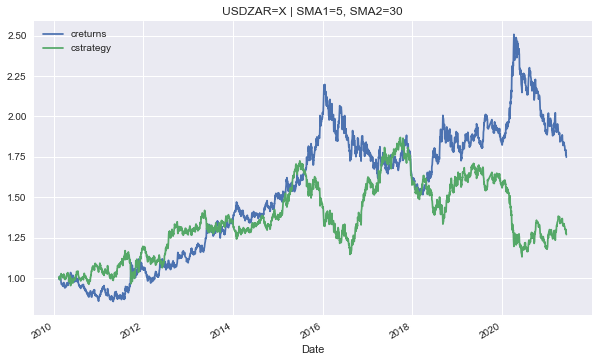

In [24]:
smabt.plot_results()

In [25]:
%%time
smabt.optimize_parameters((10, 60, 2),(100, 300, 2))

CPU times: user 25.9 s, sys: 161 ms, total: 26 s
Wall time: 26.3 s


(array([ 12., 106.]), 1.3)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

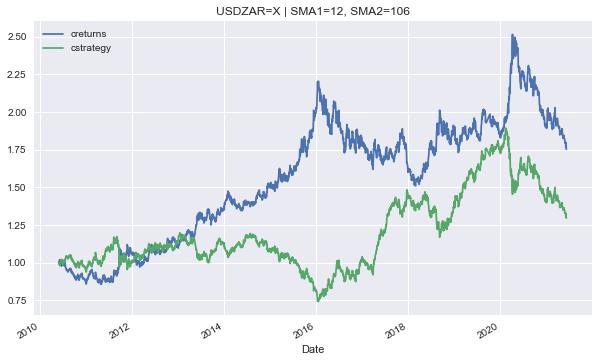

In [27]:
plt.style.use('seaborn')
smabt.plot_results()

In [56]:
scibt = ScikitVectorBacktester('USDZAR=X', '2000-01-03', '2021-06-08', 1000, 0.0, 'logistic')

[*********************100%***********************]  1 of 1 completed


In [57]:
# out-of-sample period is beginning of 2020 to date.
scibt.run_strategy('2000-01-03', '2015-12-31', '2016-01-01', '2021-06-08', lags=5)

(1071.1, 224.96)

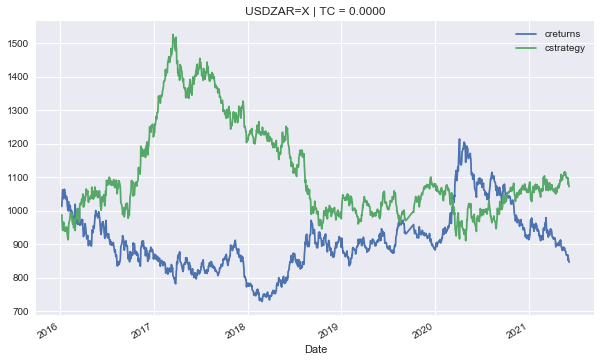

In [58]:
scibt.plot_results()

In [41]:
scibt = ScikitVectorBacktester('USDZAR=X', '2015-01-03', '2021-06-08', 1000, 0.0, 'logistic')

[*********************100%***********************]  1 of 1 completed


In [46]:
# out-of-sample period is beginning of 2020 to date.
scibt.run_strategy('2015-01-03', '2019-12-31', '2020-01-01', '2021-06-08', lags=5)

(1394.96, 450.21)

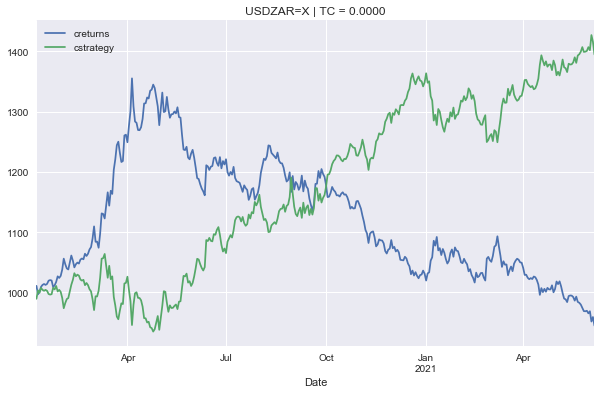

In [47]:
scibt.plot_results()